<H1>Universidad de Cuenca<H1>
<h2>Carlos Valladarez<h2>

Clasificacion de imagenes con el uso TensorFlow, mediante CNN, y el modelo VGG19
![](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)

<h2>Ejemplo Dataset<h2>

![Ejemplo del dataset](https://d3i71xaburhd42.cloudfront.net/1e1a67a78badc619b2f9938e4a03922dcbee0fb6/4-Figure2-1.png)

<h2>Contenido del dataset<h2>

![](https://d3i71xaburhd42.cloudfront.net/1e1a67a78badc619b2f9938e4a03922dcbee0fb6/4-Table1-1.png)

<h2>Cargas de librerias y datos:<h2>
- Se utilizará el modelo de CNN VGG19 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import shutil
import multiprocessing as mp
import cv2
import numpy as np
import sklearn.metrics as metrics
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import load_model
from keras.models import Sequential
from keras import optimizers
from keras.utils import to_categorical
from sklearn.utils import class_weight
from keras import layers
from keras.layers import Dense, Dropout, Activation, GlobalAveragePooling2D, MaxPooling2D, Conv2D, Input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.optimizers import SGD



from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50

%matplotlib inline

train_dir = '/kaggle/input/food11/training'
validation_dir = '/kaggle/input/food11/validation'
train_files = [f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]
validation_files = [f for f in os.listdir(validation_dir) if os.path.isfile(os.path.join(validation_dir, f))]

Using TensorFlow backend.


Extracción de labels del training y validation set

In [2]:
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Extracci'on de labels
train = []
y_train = []
valid = []
y_valid = []

for file in train_files:
    train.append(file)
    label= file.find("_")
    y_train.append(int(file[0:label]))
for file in validation_files:
    valid.append(file)
    label= file.find("_")
    y_valid.append(int(file[0:label]))

* Se crean contenedores donde se colocaran las imagenes de 190x190, para que no se sobrepase la ram, y no crashee el kernel.

In [3]:
cnnInput = np.ndarray(shape=(len(train), 190,190, 3), dtype=np.float32)
i=0
for file in train:
    image = cv2.imread(train_dir + "/" + file)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float")
    image = cv2.resize(image, dsize=(190, 190), interpolation=cv2.INTER_CUBIC)
    x = img_to_array(image)
    x = x.reshape((1, x.shape[0], x.shape[1],
                                   x.shape[2]))

    cnnInput[i]=x
    i+=1

In [4]:
cnnValidation = np.ndarray(shape=(len(valid), 190,190, 3), dtype=np.float32)
i=0
for file in valid:
    image = cv2.imread(validation_dir + "/" + file)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float")
    image = cv2.resize(image, dsize=(190, 190), interpolation=cv2.INTER_CUBIC)

    x = img_to_array(image)
    x = x.reshape((1, x.shape[0], x.shape[1],
                                   x.shape[2]))

    cnnValidation[i]=x
    i+=1


* Usamos una codificación activa en lugar del número de la clase para las etiquetas. Para obtener un resultado de probabilidades de pertenecer a cada clase.

In [5]:
y_train_2 = to_categorical(y_train)
y_valid_2 = to_categorical(y_valid)

- Cargar el modelo VGG19 preentrenado para im'agenes

In [6]:
vgg_model = VGG19(weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [7]:
# Se crea las variables hot-encoded
#hot-encoded-> representaci'on de variables categ'oricas como vectores binarios
y_train_hot_encoded = to_categorical(y_train)
y_test_hot_encoded = to_categorical(y_valid)

In [8]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [9]:
#se obtienen las capas y se agrega una capa de GlobalAveragePooling
x = vgg_model.output
x = GlobalAveragePooling2D()(x)

# se agrega una capa fully-connected 
x = Dense(2048, activation='relu')(x)
x = Dropout(0.3)(x)

# Se agregan las capas de salida
predictions = Dense(11, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=predictions)
#congelar el las capas del modelo preentrenado
for layer in vgg_model.layers:
    layer.trainable = False

# Actualizaci'on de los pesos que son agragados
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit(cnnInput, y_train_hot_encoded)

# Se eligen las capas que seran actualizadas durante el entrenamiento
layer_num = len(model.layers)
for layer in model.layers[:21]:
    layer.trainable = False

for layer in model.layers[21:]:
    layer.trainable = True

# Entrenamiento
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
#parametro que acelera el sgd en la direcci'on relevante, y amortigua las oscilaciones
#SDG stocastic gradient descent optimizer-> merodo iterativo para optimizar una funcion objetivo, con propiedades de suavidad adecuada
#history= model.fit(cnnInput,y_train_hot_encoded, batch_size=64, shuffle=True,
#                    validation_data=(cnnValidation, y_test_hot_encoded),
#                  class_weight=class_weights, epochs=100)
#history = model.fit(cnnInput, y_train_hot_encoded, batch_size=256, epochs=50, shuffle=True,  validation_split=0.1)

Epoch 1/1
9866/9866 [==============================] - 27s 3ms/step - loss: 2.4655


Desglose del modelo

In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

En esta parte, realizamos Data augmentation. Data augmentation es una forma de crear nuevos datos con modificaciones:

* diferentes orientaciones (horizontal_flip y vertical_flip)
* Con desplazamiento (desplazamiento aleatorio de imágenes horizontalmente o desplazamiento aleatorio de imágenes verticalmente)
* Zoom 
* Utilizamos este generador de imágenes para capacitación y validación, pero para el generador de imágenes de validación, se utiliza las imágenes originales del conjunto de datos de validación.
![](https://enmilocalfunciona.io/content/images/2019/02/image-10.png)

In [11]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator
# Configuraci'on de data augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[.6, 1],
    vertical_flip=True,
    horizontal_flip=True)
train_generator = train_datagen.flow(cnnInput, y_train, batch_size=64, seed=11)
valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow(cnnValidation, y_valid, batch_size=64, seed=11)

Una vez creado del generador de imagenes, este debe ser entrenado, esto mejorara el rendimiento de la transformacion de las imagenes.

In [12]:
train_datagen.fit(cnnInput)
valid_datagen.fit(cnnValidation)

In [13]:
hystory=model.fit_generator(train_datagen.flow(cnnInput, y_train_hot_encoded, batch_size=64), shuffle=True,
                    validation_data=valid_datagen.flow(cnnValidation, y_test_hot_encoded, batch_size=64),
                  class_weight=class_weights, epochs=300)

Epoch 1/300
155/155 [==============================] - 81s 525ms/step - loss: 1.2872 - accuracy: 0.5974 - val_loss: 0.9218 - val_accuracy: 0.7152
Epoch 2/300
155/155 [==============================] - 76s 488ms/step - loss: 1.1593 - accuracy: 0.6240 - val_loss: 0.9563 - val_accuracy: 0.7178
Epoch 3/300
155/155 [==============================] - 75s 486ms/step - loss: 1.1349 - accuracy: 0.6316 - val_loss: 1.0135 - val_accuracy: 0.7227
Epoch 4/300
155/155 [==============================] - 75s 485ms/step - loss: 1.0772 - accuracy: 0.6463 - val_loss: 0.7086 - val_accuracy: 0.7230
Epoch 5/300
155/155 [==============================] - 76s 490ms/step - loss: 1.0660 - accuracy: 0.6461 - val_loss: 0.5476 - val_accuracy: 0.7280
Epoch 6/300
155/155 [==============================] - 75s 487ms/step - loss: 1.0567 - accuracy: 0.6487 - val_loss: 0.5580 - val_accuracy: 0.7271
Epoch 7/300
155/155 [==============================] - 75s 483ms/step - loss: 1.0417 - accuracy: 0.6512 - val_loss: 0.6258 -

In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [15]:
model.save('modelo300.h5')
model.save_weights('pesos300.h5')

In [16]:
import matplotlib.pyplot as plt
import numpy as np

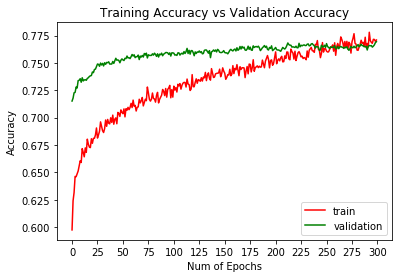

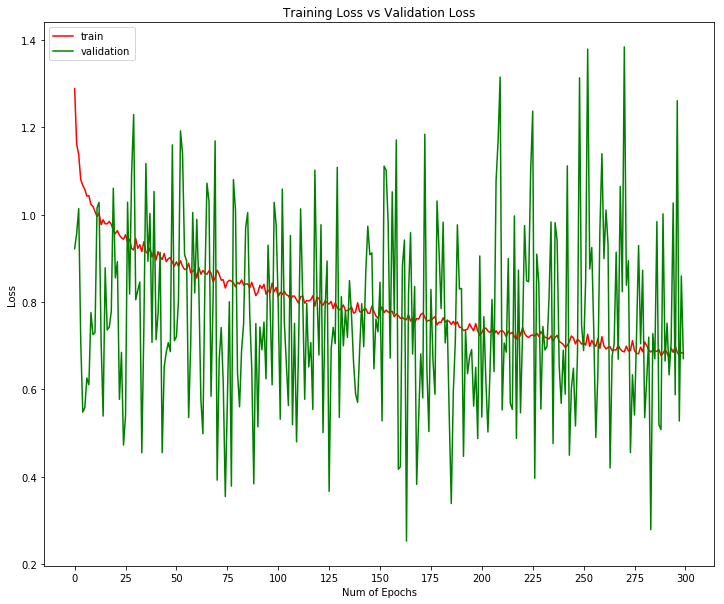

In [17]:
plt.figure(0)  
plt.plot(hystory.history['accuracy'],'r')  
plt.plot(hystory.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 301, 25.0))  
plt.rcParams['figure.figsize'] = (12,10 )  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(hystory.history['loss'],'r')  
plt.plot(hystory.history['val_loss'],'g')  
plt.xticks(np.arange(0, 301, 25.0))  
plt.rcParams['figure.figsize'] = (12, 10)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

<h2>Prueba del modelo<h2>
- Definición de la función de preducción


In [18]:

import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import tensorflow as tf 
longitud, altura = 190, 190#tamaño de la imagen
#modelo = 'modelo.h5'#direccion del modelo
#pesos_modelo = 'pesos.h5'#direccion de los pesos
#model = tf.keras.models.load_model(modelo)#cargar modelo
#model.load_weights(pesos_modelo)#cargar pesos
#funcion de prediccion
def predict(file):
  x = tf.keras.preprocessing.image.load_img(file, target_size=(longitud, altura))#cargar la imagen
  x = tf.keras.preprocessing.image.img_to_array(x)#tansformar imagen a arreglo
  x = np.expand_dims(x, axis=0)#en el eje 0 se agrega una dimención extra para procesar la información sin problema
  array = model.predict(x)#se llama a la red para realizar la predicción
  result = array[0]#obtenemos el resultado
  answer = np.argmax(result)#nos entrega el indice del valor mas alto
  #clasificación del resultado
  if answer == 0:
    print(file+" pred: Pan 0")
  elif answer == 1:
    print(file+" pred: Lacteo 1")
  elif answer == 2:
    print(file+" pred: Postre 2")
  elif answer == 3:
    print(file+" pred: Huevos 3")
  elif answer == 4:
    print(file+" pred: Fritura 4")
  elif answer == 5:
    print(file+" pred: Carne 5")
  elif answer == 6:
    print(file+" pred: Pasta 6")
  elif answer == 7:
    print(file+" pred: Arroz 7")
  elif answer == 8:
    print(file+" pred: Marisco 8")
  elif answer == 9:
    print(file+" pred: Sopa 9")
  elif answer == 10:
    print(file+" pred: Fruta-Verdura 10")
  return answer

- Función de creación de ruta

In [19]:
from os import scandir, getcwd
def ls(ruta = getcwd()):
    return [arch.name for arch in scandir(ruta) if arch.is_file()]

- Prueba de la evaluación

In [20]:
lista_arq = ls('/kaggle/input/food11/evaluation') 
true=0
for i in lista_arq:
   p=predict('/kaggle/input/food11/evaluation/'+i)
   if(str(p)==i[0]):
     true=true+1
print(100*true/len(lista_arq))

/kaggle/input/food11/evaluation/0_366.jpg pred: Pan 0
/kaggle/input/food11/evaluation/3_49.jpg pred: Huevos 3
/kaggle/input/food11/evaluation/6_88.jpg pred: Pasta 6
/kaggle/input/food11/evaluation/2_172.jpg pred: Postre 2
/kaggle/input/food11/evaluation/3_125.jpg pred: Huevos 3
/kaggle/input/food11/evaluation/10_112.jpg pred: Fruta-Verdura 10
/kaggle/input/food11/evaluation/3_330.jpg pred: Postre 2
/kaggle/input/food11/evaluation/4_206.jpg pred: Fritura 4
/kaggle/input/food11/evaluation/9_275.jpg pred: Sopa 9
/kaggle/input/food11/evaluation/9_262.jpg pred: Sopa 9
/kaggle/input/food11/evaluation/3_274.jpg pred: Huevos 3
/kaggle/input/food11/evaluation/5_97.jpg pred: Carne 5
/kaggle/input/food11/evaluation/9_115.jpg pred: Sopa 9
/kaggle/input/food11/evaluation/5_79.jpg pred: Carne 5
/kaggle/input/food11/evaluation/2_100.jpg pred: Lacteo 1
/kaggle/input/food11/evaluation/10_62.jpg pred: Arroz 7
/kaggle/input/food11/evaluation/9_131.jpg pred: Postre 2
/kaggle/input/food11/evaluation/3_179.